In [117]:
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import random
import scipy.stats as stats

In [229]:
#dataset = 'spark'
#ped_file = '../../DATA/spark/sparkfam.ped.quads.ped'

dataset = 'ssc.hg38'
ped_file = '../../DATA/ssc.hg38/ssc.ped'

chroms = [str(x) for x in range(1, 23)]

In [230]:
with open('../../PhasingFamilies/recomb_%s/sibpairs.json' % dataset, 'r') as f:
    sibpairs = json.load(f)
print('sibpairs', len(sibpairs))

sibpairs 1903


In [231]:
def pull_phenotype_ped(ped_file):
	sample_to_sex = dict()
	sample_to_affected = dict()
	parents_to_children = defaultdict(list)
	with open(ped_file, 'r') as f:
		for line in f:
			pieces = line.strip().split('\t')
			sample_to_sex[pieces[1]] = pieces[4]
			sample_to_sex[pieces[3]] = '2'
			sample_to_sex[pieces[2]] = '1'
			sample_to_affected[pieces[1]] = pieces[5]
			parents_to_children[(pieces[0], pieces[3], pieces[2])].append(pieces[1])
	return sample_to_affected, sample_to_sex, parents_to_children

sample_to_affected, sample_to_sex, parents_to_children = pull_phenotype_ped(ped_file)

In [232]:
def pull_positions(chrom):
    start_poss, end_poss, label = [], [], []
    with open('../data/cytoband38.txt', 'r') as f:
        for line in f:
            pieces = line.strip().split('\t')
            if pieces[0]=='chr%s' % chrom:
                start_poss.append(int(pieces[1]))
                end_poss.append(int(pieces[2]))
                label.append(pieces[3])
    return start_poss, end_poss, label
    


In [233]:
def pull_ibd(chrom, sibpairs, start_poss):
    is_mat_match, is_pat_match, is_both_match = np.zeros((len(sibpairs), len(start_poss)), dtype=int), np.zeros((len(sibpairs), len(start_poss)), dtype=int), np.zeros((len(sibpairs), len(start_poss)), dtype=int)
    for i, sibpair in enumerate(sibpairs):
        with open('../../PhasingFamilies/%s/%s.phased.txt' % (sibpair['phase_dir'], sibpair['family']), 'r') as f:
            for line in f:
                if line.startswith('chr%s\t' % chrom):
                    pieces = line.strip().split('\t')
                    start_pos, end_pos = int(pieces[-2]), int(pieces[-1])
                    mat_ibd, pat_ibd, both_ibd = 0, 0, 0
                    if pieces[13]=='0' and pieces[9]!='-1' and pieces[11]!='-1':
                        if pieces[9]==pieces[11]:
                            mat_ibd = 1
                        else:
                            mat_ibd = -1
                    if pieces[13]=='0' and pieces[10]!='-1' and pieces[12]!='-1':
                        if pieces[10]==pieces[12]:
                            pat_ibd = 1
                        else:
                            pat_ibd = -1
                    if pieces[13]=='0' and pieces[9]!='-1' and pieces[10]!='-1' and pieces[11]!='-1' and pieces[12]!='-1':
                        if pieces[9]==pieces[11] and pieces[10]==pieces[12]:
                            both_ibd = 1
                        else:
                            both_ibd = -1
                            
                    start_index, end_index = np.searchsorted(start_poss, [start_pos, end_pos])
                    for j in range(max(0, start_index-1), min(len(start_poss), end_index+1)):
                        overlap = np.clip(min(end_poss[j], end_pos) - max(start_poss[j], start_pos), 0, None)
                        is_mat_match[i, j] += overlap*mat_ibd
                        is_pat_match[i, j] += overlap*pat_ibd
                        is_both_match[i, j] += overlap*both_ibd
                        
    # we go from is_mat_match containing ibd-noibd bp to 
    # 1 if the region is mostly ibd
    # -1 if the region is mostly noibd
    is_mat_match = np.sign(is_mat_match)
    is_pat_match = np.sign(is_pat_match)
    is_both_match = np.sign(is_both_match)
    return is_mat_match, is_pat_match, is_both_match
    



In [234]:
def pull_sibpair_indices(aff, sibpairs):
    # first, pull all sibpairs with given affected status
    sps = [(x, i) for (i, x) in enumerate(sibpairs) if (sample_to_affected[x['sibling1']] in {'1', '2'}) and \
                                  (sample_to_affected[x['sibling2']] in {'1', '2'}) and \
           int(sample_to_affected[x['sibling1']]=='2')+int(sample_to_affected[x['sibling2']]=='2')==aff]
    
    # now make sure we don't include the same child in multiple sibpairs
    random.shuffle(sps)
    
    fam_ind_sps = []
    included = set()
    for sp, i in sps:
        if sp['sibling1'] not in included or sp['sibling2'] not in included:
            fam_ind_sps.append(i)
            included.add(sp['sibling1'])
            included.add(sp['sibling2'])
    return fam_ind_sps

ntnt_sibpairs = pull_sibpair_indices(0, sibpairs)
autnt_sibpairs = pull_sibpair_indices(1, sibpairs)
autaut_sibpairs = pull_sibpair_indices(2, sibpairs)
print('ntnt', len(ntnt_sibpairs), 'autnt', len(autnt_sibpairs), 'autaut', len(autaut_sibpairs))
    

ntnt 0 autnt 1903 autaut 0


In [235]:
def run_binom_test(is_match, p=0.5):
    pvalues = np.zeros((is_match.shape[1],))
    for i in range(is_match.shape[1]):
        pvalues[i] = stats.binom_test(np.sum(is_match[:, i]==1), np.sum(is_match[:, i]!=0), p, alternative='greater')
    return pvalues
      
def run_chi2_test(is_match_concord, is_match_discord):
    pvalues = np.zeros((is_match_concord.shape[1],))
    for i in range(is_match_concord.shape[1]):
        pvalues[i] = stats.chi2_contingency([[np.sum(is_match_concord[:, i]==1), np.sum(is_match_concord[:, i]==-1)],
                                             [np.sum(is_match_discord[:, i]==1), np.sum(is_match_discord[:, i]==-1)]])[1]
    return pvalues

In [ ]:
chrs, start_posss, end_posss, labels = [], [], [], []
autaut_mat_pvalues, autaut_pat_pvalues, autaut_both_pvalues, autaut_sum_pvalues = [], [], [], []
ntnt_mat_pvalues, ntnt_pat_pvalues, ntnt_both_pvalues, ntnt_sum_pvalues = [], [], [], []

for chrom in chroms:
    print(chrom, end=' ')
    start_poss, end_poss, label = pull_positions(chrom)
    is_mat_match, is_pat_match, is_both_match = pull_ibd(chrom, sibpairs, start_poss)

    #autaut_mat_pvalues.append(run_binom_test(is_mat_match[autaut_sibpairs, :]))
    #autaut_pat_pvalues.append(run_binom_test(is_pat_match[autaut_sibpairs, :]))
    #autaut_both_pvalues.append(run_binom_test(is_both_match[autaut_sibpairs, :], p=0.25))
    #autaut_sum_pvalues.append(run_binom_test(np.vstack((is_mat_match[autaut_sibpairs, :], is_pat_match[autaut_sibpairs, :]))))

    autaut_mat_pvalues.append(run_binom_test(is_mat_match[autnt_sibpairs, :]))
    autaut_pat_pvalues.append(run_binom_test(is_pat_match[autnt_sibpairs, :]))
    autaut_both_pvalues.append(run_binom_test(is_both_match[autnt_sibpairs, :], p=0.25))
    autaut_sum_pvalues.append(run_binom_test(np.vstack((is_mat_match[autnt_sibpairs, :], is_pat_match[autnt_sibpairs, :]))))

    #autaut_mat_pvalues.append(run_chi2_test(is_mat_match[autaut_sibpairs, :], is_mat_match[autnt_sibpairs, :]))
    #autaut_pat_pvalues.append(run_chi2_test(is_pat_match[autaut_sibpairs, :], is_pat_match[autnt_sibpairs, :]))
    #autaut_both_pvalues.append(run_chi2_test(is_both_match[autaut_sibpairs, :], is_both_match[autnt_sibpairs, :]))
    #autaut_sum_pvalues.append(run_chi2_test(np.vstack((is_mat_match[autaut_sibpairs, :], is_pat_match[autaut_sibpairs, :])),
    #                                        np.vstack((is_mat_match[autnt_sibpairs, :], is_pat_match[autnt_sibpairs, :]))))

    ntnt_mat_pvalues.append(run_binom_test(is_mat_match[ntnt_sibpairs, :]))
    ntnt_pat_pvalues.append(run_binom_test(is_pat_match[ntnt_sibpairs, :]))
    ntnt_both_pvalues.append(run_binom_test(is_both_match[ntnt_sibpairs, :], p=0.25))
    ntnt_sum_pvalues.append(run_binom_test(np.vstack((is_mat_match[ntnt_sibpairs, :], is_pat_match[ntnt_sibpairs, :]))))
    
    start_posss.extend(start_poss)
    end_posss.extend(end_poss)
    labels.extend(label)
    chrs.extend([chrom]*len(label))



1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 

In [217]:
autaut_mat_pvalues = np.hstack(autaut_mat_pvalues)
autaut_pat_pvalues = np.hstack(autaut_pat_pvalues)
autaut_both_pvalues = np.hstack(autaut_both_pvalues)
autaut_sum_pvalues = np.hstack(autaut_sum_pvalues)

ntnt_mat_pvalues = np.hstack(ntnt_mat_pvalues)
ntnt_pat_pvalues = np.hstack(ntnt_pat_pvalues)
ntnt_both_pvalues = np.hstack(ntnt_both_pvalues)
ntnt_sum_pvalues = np.hstack(ntnt_sum_pvalues)

In [218]:
chrom_starts = []
for i, ch in enumerate(chrs):
    if len(chrom_starts)==0 or chrs[chrom_starts[-1]] != ch:
        chrom_starts.append(i)

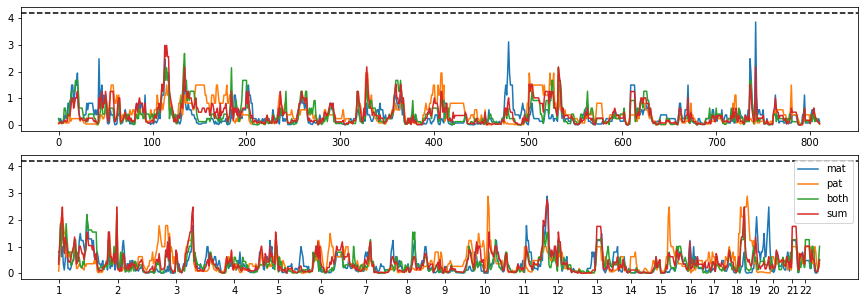

In [219]:
plt.figure(figsize=(15, 5))

plt.subplot(2, 1, 1)
plt.plot(-np.log10(autaut_mat_pvalues), label='mat')
plt.plot(-np.log10(autaut_pat_pvalues), label='pat')
plt.plot(-np.log10(autaut_both_pvalues), label='both')
plt.plot(-np.log10(autaut_sum_pvalues), label='sum')

plt.axhline(-np.log10(0.05/autaut_mat_pvalues.shape[0]), color='black', linestyle='--')

plt.subplot(2, 1, 2)
plt.plot(-np.log10(ntnt_mat_pvalues), label='mat')
plt.plot(-np.log10(ntnt_pat_pvalues), label='pat')
plt.plot(-np.log10(ntnt_both_pvalues), label='both')
plt.plot(-np.log10(ntnt_sum_pvalues), label='sum')

plt.axhline(-np.log10(0.05/autaut_mat_pvalues.shape[0]), color='black', linestyle='--')
plt.xticks(chrom_starts, chroms)

plt.legend()
plt.show()

In [220]:
print([chrs[i]+labels[i] for i in np.where(-np.log10(autaut_both_pvalues)>-np.log10(0.05/autaut_mat_pvalues.shape[0]))[0]])
  
      

[]


In [221]:
chrom = '8'
start_poss, end_poss, label = pull_positions(chrom)
is_mat_match, is_pat_match, is_both_match = pull_ibd(chrom, sibpairs, start_poss)



In [222]:
i = np.where([l=='q21.11' for l in label])[0]
print(stats.binom_test([np.sum(is_mat_match[autaut_sibpairs, i]==1), np.sum(is_mat_match[autaut_sibpairs, i]==-1)]))
print(stats.binom_test([np.sum(is_pat_match[autaut_sibpairs, i]==1), np.sum(is_pat_match[autaut_sibpairs, i]==-1)], alternative='greater'))
print()
print(stats.binom_test([np.sum(is_mat_match[ntnt_sibpairs, i]==1), np.sum(is_mat_match[ntnt_sibpairs, i]==-1)], alternative='greater'))
print(stats.binom_test([np.sum(is_pat_match[ntnt_sibpairs, i]==1), np.sum(is_pat_match[ntnt_sibpairs, i]==-1)], alternative='greater'))
print()
print(stats.binom_test([np.sum(is_mat_match[autnt_sibpairs, i]==1), np.sum(is_mat_match[autnt_sibpairs, i]==-1)], alternative='greater'))
print(stats.binom_test([np.sum(is_pat_match[autnt_sibpairs, i]==1), np.sum(is_pat_match[autnt_sibpairs, i]==-1)], alternative='greater'))

1.0
0.2706280946731568

0.5561375863296087
0.4438624136703913

0.44027995870205466
0.8164430776010001


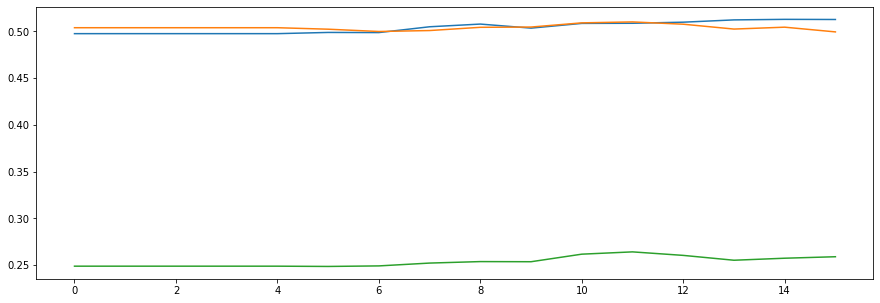

In [116]:
plt.figure(figsize=(15, 5))
plt.plot(np.sum(is_mat_match==1, axis=0)/is_mat_match.shape[0])
plt.plot(np.sum(is_pat_match==1, axis=0)/is_pat_match.shape[0])
plt.plot(np.sum(is_both_match==1, axis=0)/is_both_match.shape[0])
plt.show()